# Bayesian Time Series Models

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pymc as pm
import arviz as az
import dill
import os
import re

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from thesis_tools.utils.data import *
from thesis_tools.utils.latex import *
from thesis_tools.utils.model_fitting import *
from thesis_tools.models.frequentist import *
from thesis_tools.models.bayesian_univariate_time_series import *
from thesis_tools.statistical_tests.tests import *

## Preliminaries

In [4]:
df = read_panel_data(observations_threshold=0)

In [5]:
path = "../../Stored_Models/bayesian_univariate_time_series/"
model_files = os.listdir(path)

# Define regex pattern to match the desired information
pattern = re.compile(r'^(.*)_(Pareto|Weibull|GeneralisedPareto)_(\d{4})_(\d{4})_(.*)\.pkl$')

# Function to extract information from a string
def extract_info(file_name):
    match = pattern.match(file_name)
    if match:
        country = match.group(1).replace('_', ' ')
        model = match.group(2)
        start_year = match.group(3)
        end_year = match.group(4)
        covariates_str = match.group(5)
        covariates = re.split(r'_(?=constant|log_change_[a-zA-Z0-9]+)', covariates_str)
        return {
            'Group': country,
            'Model': model,
            'Start Year': int(start_year),
            'End Year': int(end_year),
            'Covariates': covariates
        }
    else:
        return None

# Extract information for each file name
extracted_info = [extract_info(file_name) for file_name in model_files]
models_df = pd.DataFrame([info for info in extracted_info if info is not None])

In [6]:
models_df

Group              Model  Start Year  End Year  \
0             Canada  GeneralisedPareto        2010      2019   
1            Germany            Weibull        2005      2019   
2               U.S.  GeneralisedPareto        2005      2021   
3        Scandinavia            Weibull        2016      2021   
4              India            Weibull        2009      2019   
..               ...                ...         ...       ...   
206             U.S.            Weibull        2005      2020   
207  Israel + Turkey            Weibull        2010      2019   
208  British Islands            Weibull        2007      2019   
209            Italy            Weibull        2014      2021   
210  Israel + Turkey             Pareto        2010      2020   

                                          Covariates  
0     [constant, log_change_gdp_pc, log_change_MSCI]  
1                      [constant, log_change_gdp_pc]  
2                      [constant, log_change_gdp_pc]  
3    [constant, log_change_gdp_pc, log_change_OMX40]  
4                      [constant, log_change_gdp_pc]  
..                                               ...  
206                    [constant, log_change_gdp_pc]  
207   [constant, log_change_gdp_pc, log_change_MSCI]  
208                    [constant, log_change_gdp_pc]  
209   [constant, log_change_gdp_pc, log_change_MSCI]  
210                    [constant, log_change_gdp_pc]  

[211 rows x 5 columns]

## Evaluation

### Evaluating fit

In [7]:
path = "../../Stored_Results/bayesian_time_series_analysis/test_statistic_df.pkl"
rebuild = False

if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        test_statistic_df = dill.load(f)
else:
    # iterate over all models
    test_statistic_dict = {}
    for i, row in models_df.iterrows():
        model = train_or_retrieve_time_series_model(
            panel_df=df,
            group=row['Group'],
            start_year=row['Start Year'],
            end_year=row['End Year'],
            model_type=row['Model'],
            covariates=row['Covariates'],
            retrain_if_saved=False
        )
        posterior_predictive = model.posterior_predictive()
        prev_true_mean = np.nan
        for year in range(row['Start Year'], row['End Year'] + 1):
            # Problem: sometimes more than 15 training years were suggested, but the dataframe was truncated. Hence, check that the data is available
            if year < row['End Year'] - 14:
                continue
            true_data = df[(df['group'] == row['Group']) & (df['year'] == year)]['net_worth'].values[0]
            post_data = posterior_predictive[f'y_{year}']
            KS_stat, KS_p_value = Kolmogorov_Smirnov_two_sample_test(data1=true_data, data2=post_data)
            _, CM_stat = Anderson_Darling_statistic(data_1=true_data, data_2=post_data, weight_function='Cramer-von Mises')
            _, AD_stat = Anderson_Darling_statistic(data_1=true_data, data_2=post_data, weight_function='Anderson-Darling')
            test_statistic_dict[(row['Group'], row['Start Year'], row['End Year'], row['Model'], str(row['Covariates']), len(row['Covariates']), year, False, 0)] = {
                'KS_stat': KS_stat,
                'KS_pval': KS_p_value,
                'CM_stat': CM_stat,
                'AD_stat': AD_stat,
                'true_mean': np.mean(true_data),
                'pred_mean': np.mean(post_data),
                'prev_true_mean': prev_true_mean
            }
            prev_true_mean = np.mean(true_data)
        oos_predictive = model.predict()
        for year in range(row['End Year']+1, 2023):
            true_data = df[(df['group'] == row['Group']) & (df['year'] == year)]['net_worth'].values[0]
            pred_data = oos_predictive[f'y_{year}']
            KS_stat, KS_p_value = Kolmogorov_Smirnov_two_sample_test(data1=true_data, data2=pred_data)
            _, CM_stat = Anderson_Darling_statistic(data_1=true_data, data_2=pred_data, weight_function='Cramer-von Mises')
            _, AD_stat = Anderson_Darling_statistic(data_1=true_data, data_2=pred_data, weight_function='Anderson-Darling')
            test_statistic_dict[(row['Group'], row['Start Year'], row['End Year'], row['Model'], str(row['Covariates']), len(row['Covariates']), year, True, year-row['End Year'])] = {
                'KS_stat': KS_stat,
                'KS_pval': KS_p_value,
                'CM_stat': CM_stat,
                'AD_stat': AD_stat,
                'true_mean': np.mean(true_data),
                'pred_mean': np.mean(pred_data),
                'prev_true_mean': prev_true_mean
            }
            prev_true_mean = np.mean(true_data)
    test_statistic_df = pd.DataFrame(test_statistic_dict).T
    test_statistic_df.index.names = ['Group', 'Start Year', 'End Year', 'Model', 'Covariates', 'nCovariates', 'Year', 'OOS', 'Steps Ahead']
    test_statistic_df['pred_mean_resid'] = test_statistic_df['true_mean'] - test_statistic_df['pred_mean']
    test_statistic_df['rw_mean_resid'] = test_statistic_df['true_mean'] - test_statistic_df['prev_true_mean']

    with open(path, 'wb') as f:
        dill.dump(test_statistic_df, f)

#### In-sample fit

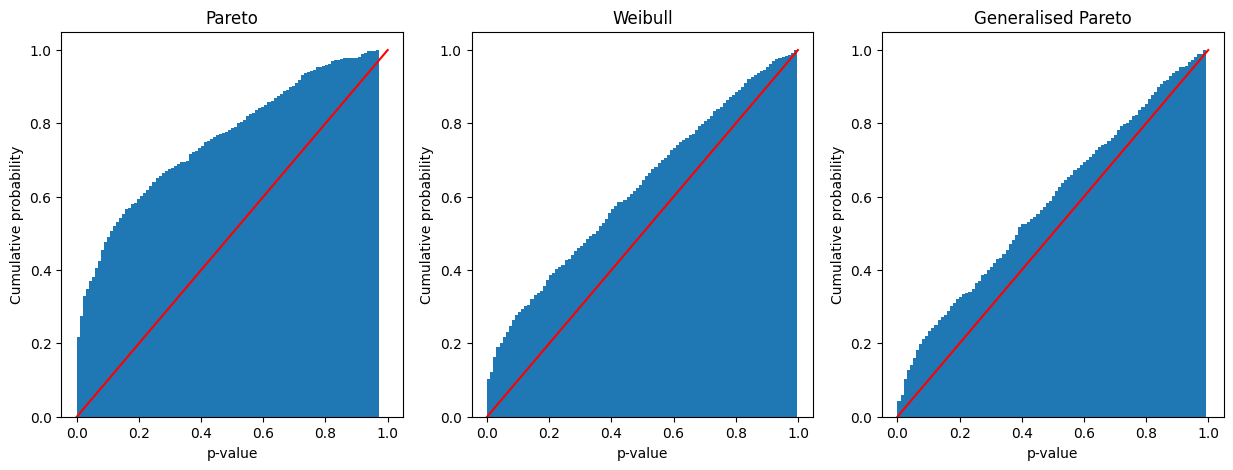

In [8]:
# Plot the cumulative cdf for of the KS_pval for Pareto, Weibull and Generalised Pareto models, where OOS is False
pareto_pvals = test_statistic_df.xs('Pareto', level='Model').xs(False, level='OOS')['KS_pval']
weibull_pvals = test_statistic_df.xs('Weibull', level='Model').xs(False, level='OOS')['KS_pval']
genpareto_pvals = test_statistic_df.xs('GeneralisedPareto', level='Model').xs(False, level='OOS')['KS_pval']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='red')
ax[0].set_xlabel('p-value')
ax[0].set_ylabel('Cumulative probability')
ax[0].set_title('Pareto')
ax[1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='red')
ax[1].set_xlabel('p-value')
ax[1].set_ylabel('Cumulative probability')
ax[1].set_title('Weibull')
ax[2].hist(genpareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[2].plot(x, x, color='red')
ax[2].set_xlabel('p-value')
ax[2].set_ylabel('Cumulative probability')
ax[2].set_title('Generalised Pareto')
plt.show()


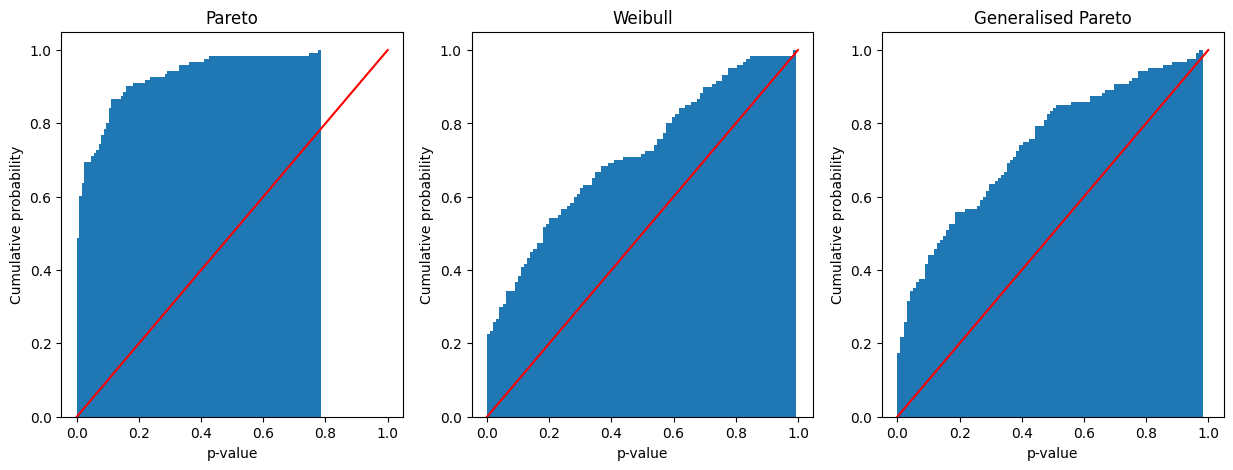

In [9]:
# Plot the cumulative cdf for of the KS_pval for Pareto, Weibull and Generalised Pareto models, where OOS is True
pareto_pvals = test_statistic_df.xs('Pareto', level='Model').xs(True, level='OOS')['KS_pval']
weibull_pvals = test_statistic_df.xs('Weibull', level='Model').xs(True, level='OOS')['KS_pval']
genpareto_pvals = test_statistic_df.xs('GeneralisedPareto', level='Model').xs(True, level='OOS')['KS_pval']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='red')
ax[0].set_xlabel('p-value')
ax[0].set_ylabel('Cumulative probability')
ax[0].set_title('Pareto')
ax[1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='red')
ax[1].set_xlabel('p-value')
ax[1].set_ylabel('Cumulative probability')
ax[1].set_title('Weibull')
ax[2].hist(genpareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[2].plot(x, x, color='red')
ax[2].set_xlabel('p-value')
ax[2].set_ylabel('Cumulative probability')
ax[2].set_title('Generalised Pareto')
plt.show()


#### Out of sample fit

In [10]:
only_one_step_ahead = test_statistic_df.xs(1, level='Steps Ahead')

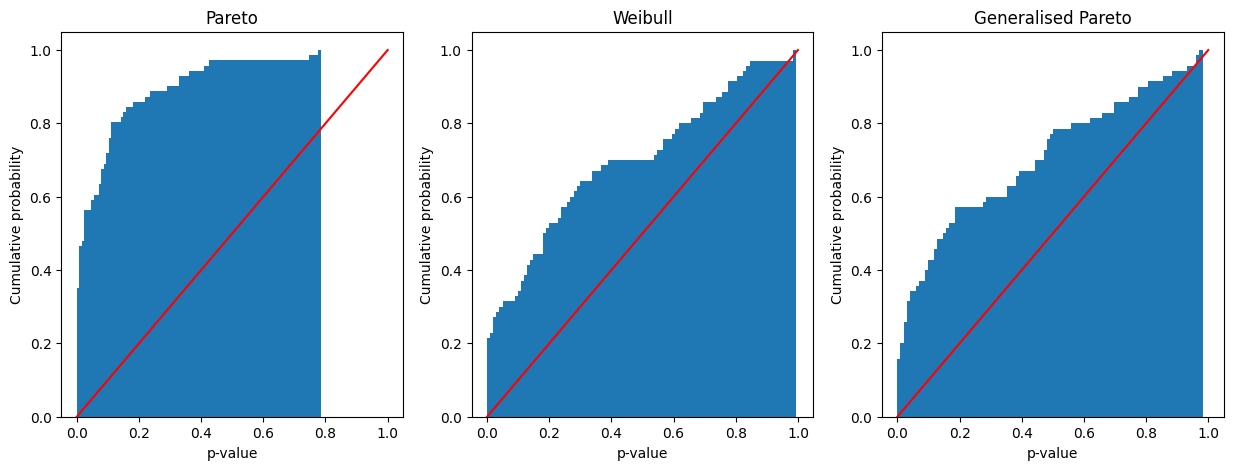

In [11]:
pareto_pvals = only_one_step_ahead.xs('Pareto', level='Model')['KS_pval']
weibull_pvals = only_one_step_ahead.xs('Weibull', level='Model')['KS_pval']
genpareto_pvals = only_one_step_ahead.xs('GeneralisedPareto', level='Model')['KS_pval']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='red')
ax[0].set_xlabel('p-value')
ax[0].set_ylabel('Cumulative probability')
ax[0].set_title('Pareto')
ax[1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='red')
ax[1].set_xlabel('p-value')
ax[1].set_ylabel('Cumulative probability')
ax[1].set_title('Weibull')
ax[2].hist(genpareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[2].plot(x, x, color='red')
ax[2].set_xlabel('p-value')
ax[2].set_ylabel('Cumulative probability')
ax[2].set_title('Generalised Pareto')
plt.show()

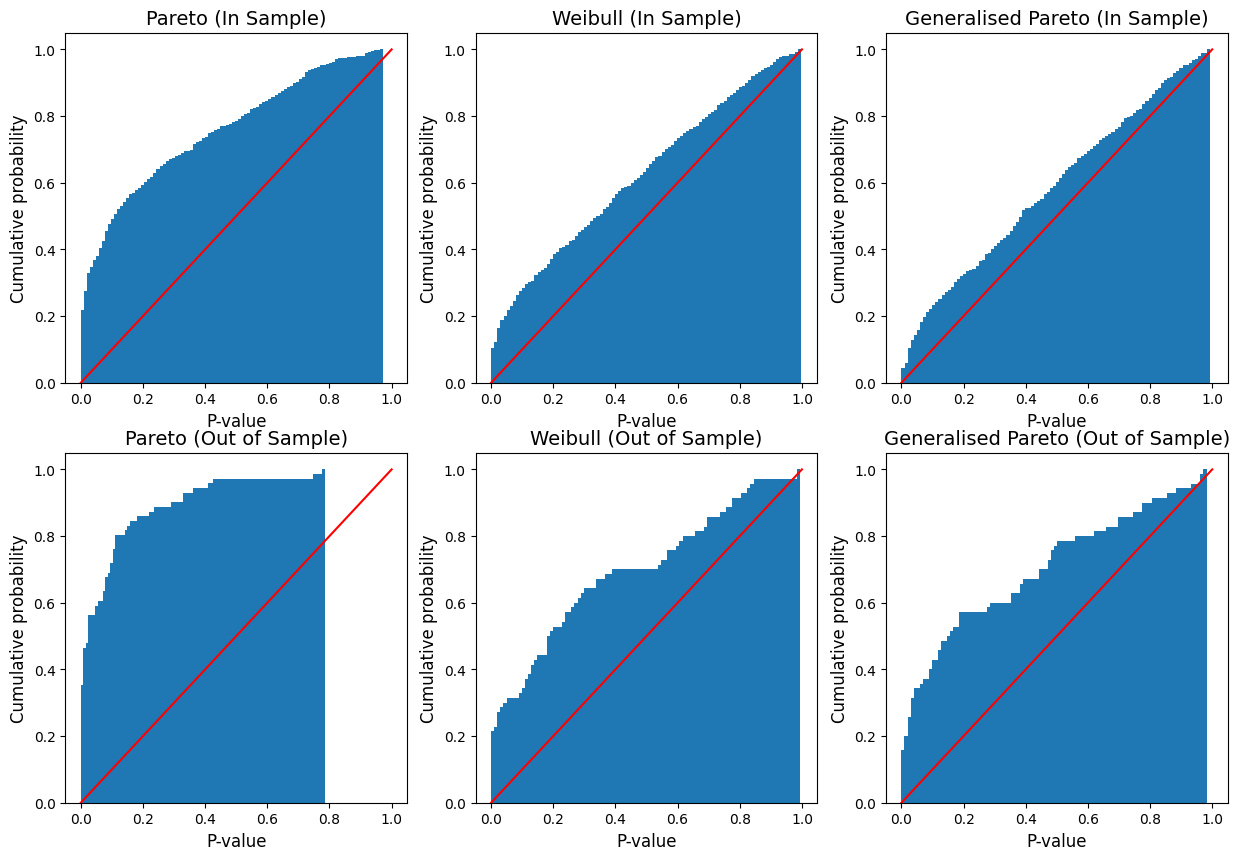

In [12]:
# make one plot with 1) the in sample KS p-values, 2) the out of sample, one step-ahead KS p-values
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
n_bins = 100
x = np.linspace(0, 1, 100)
pareto_pvals_insample = test_statistic_df.xs('Pareto', level='Model').xs(False, level='OOS')['KS_pval']
weibull_pvals_insample = test_statistic_df.xs('Weibull', level='Model').xs(False, level='OOS')['KS_pval']
genpareto_pvals_insample = test_statistic_df.xs('GeneralisedPareto', level='Model').xs(False, level='OOS')['KS_pval']
pareto_pvals_oos = only_one_step_ahead.xs('Pareto', level='Model')['KS_pval']
weibull_pvals_oos = only_one_step_ahead.xs('Weibull', level='Model')['KS_pval']
genpareto_pvals_oos = only_one_step_ahead.xs('GeneralisedPareto', level='Model')['KS_pval']

ax[0, 0].hist(pareto_pvals_insample, bins=n_bins, cumulative=True, density=True)
ax[0, 0].plot(x, x, color='red')
ax[0, 0].set_xlabel('P-value', fontsize=12)
ax[0, 0].set_ylabel('Cumulative probability', fontsize=12)
ax[0, 0].set_title('Pareto (In Sample)', fontsize=14)
ax[0, 1].hist(weibull_pvals_insample, bins=n_bins, cumulative=True, density=True)
ax[0, 1].plot(x, x, color='red')
ax[0, 1].set_xlabel('P-value', fontsize=12)
ax[0, 1].set_ylabel('Cumulative probability', fontsize=12)
ax[0, 1].set_title('Weibull (In Sample)', fontsize=14)
ax[0, 2].hist(genpareto_pvals_insample, bins=n_bins, cumulative=True, density=True)
ax[0, 2].plot(x, x, color='red')
ax[0, 2].set_xlabel('P-value', fontsize=12)
ax[0, 2].set_ylabel('Cumulative probability', fontsize=12)
ax[0, 2].set_title('Generalised Pareto (In Sample)', fontsize=14)
ax[1, 0].hist(pareto_pvals_oos, bins=n_bins, cumulative=True, density=True)
ax[1, 0].plot(x, x, color='red')
ax[1, 0].set_xlabel('P-value', fontsize=12)
ax[1, 0].set_ylabel('Cumulative probability', fontsize=12)
ax[1, 0].set_title('Pareto (Out of Sample)', fontsize=14)
ax[1, 1].hist(weibull_pvals_oos, bins=n_bins, cumulative=True, density=True)
ax[1, 1].plot(x, x, color='red')
ax[1, 1].set_xlabel('P-value', fontsize=12)
ax[1, 1].set_ylabel('Cumulative probability', fontsize=12)
ax[1, 1].set_title('Weibull (Out of Sample)', fontsize=14)
ax[1, 2].hist(genpareto_pvals_oos, bins=n_bins, cumulative=True, density=True)
ax[1, 2].plot(x, x, color='red')
ax[1, 2].set_xlabel('P-value', fontsize=12)
ax[1, 2].set_ylabel('Cumulative probability', fontsize=12)
ax[1, 2].set_title('Generalised Pareto (Out of Sample)', fontsize=14)
plt.show()

### Mean Wealth Predictions

In [13]:
only_gdp_cov = test_statistic_df.xs(2, level='nCovariates').xs(1, level='Steps Ahead')

In [14]:
mean_wealth_pareto_resids = only_gdp_cov.xs('Pareto', level='Model')[['pred_mean_resid', 'rw_mean_resid']]
mean_wealth_weibull_resids = only_gdp_cov.xs('Weibull', level='Model')[['pred_mean_resid', 'rw_mean_resid']]
mean_wealth_genpareto_resids = only_gdp_cov.xs('GeneralisedPareto', level='Model')[['pred_mean_resid', 'rw_mean_resid']]
dfs = [mean_wealth_pareto_resids, mean_wealth_weibull_resids, mean_wealth_genpareto_resids]
for df in dfs:
    df['pred_mean_abs_resid'] = np.abs(df['pred_mean_resid'])
    df['rw_mean_abs_resid'] = np.abs(df['rw_mean_resid'])

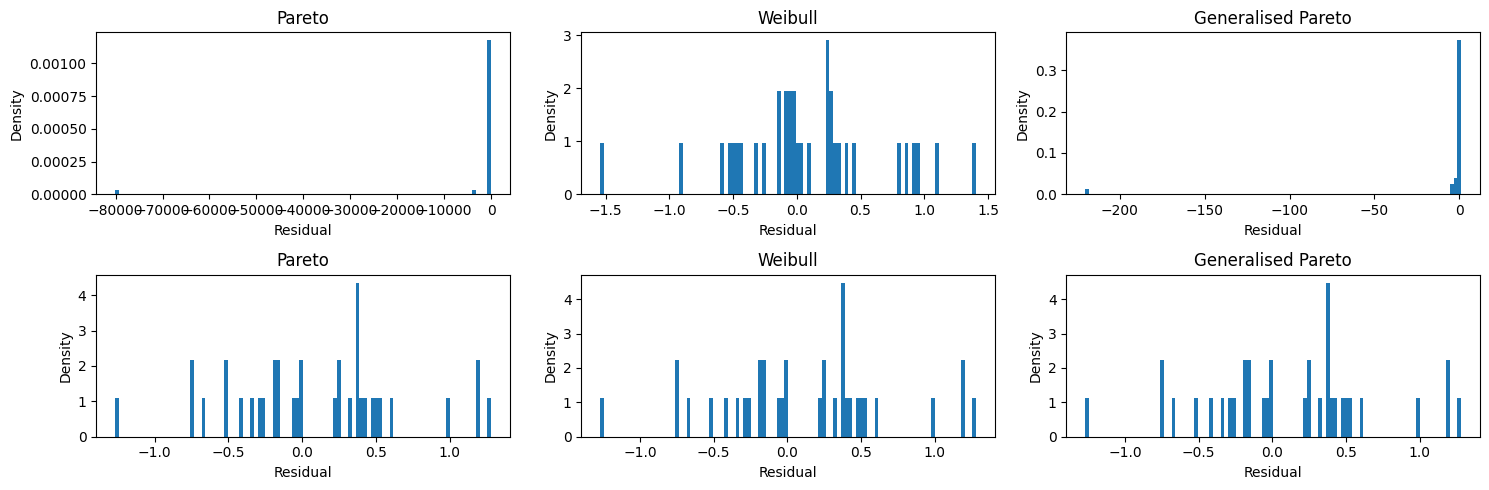

In [15]:
# For Pareto, Weibull and Generalised Pareto models, plot the residuals of the predicted mean and the random walk mean
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0, 0].hist(mean_wealth_pareto_resids['pred_mean_resid'], bins=100, density=True)
ax[0, 0].set_xlabel('Residual')
ax[0, 0].set_ylabel('Density')
ax[0, 0].set_title('Pareto')
ax[0, 1].hist(mean_wealth_weibull_resids['pred_mean_resid'], bins=100, density=True)
ax[0, 1].set_xlabel('Residual')
ax[0, 1].set_ylabel('Density')
ax[0, 1].set_title('Weibull')
ax[0, 2].hist(mean_wealth_genpareto_resids['pred_mean_resid'], bins=100, density=True)
ax[0, 2].set_xlabel('Residual')
ax[0, 2].set_ylabel('Density')
ax[0, 2].set_title('Generalised Pareto')
ax[1, 0].hist(mean_wealth_pareto_resids['rw_mean_resid'], bins=100, density=True)
ax[1, 0].set_xlabel('Residual')
ax[1, 0].set_ylabel('Density')
ax[1, 0].set_title('Pareto')
ax[1, 1].hist(mean_wealth_weibull_resids['rw_mean_resid'], bins=100, density=True)
ax[1, 1].set_xlabel('Residual')
ax[1, 1].set_ylabel('Density')
ax[1, 1].set_title('Weibull')
ax[1, 2].hist(mean_wealth_genpareto_resids['rw_mean_resid'], bins=100, density=True)
ax[1, 2].set_xlabel('Residual')
ax[1, 2].set_ylabel('Density')
ax[1, 2].set_title('Generalised Pareto')
plt.tight_layout()
plt.show()

In [16]:
# Make some summary statistics of the residuals
mean_wealth_pareto_resids.describe()

pred_mean_resid  rw_mean_resid  pred_mean_abs_resid  rw_mean_abs_resid
count        36.000000      36.000000            36.000000          36.000000
mean      -2385.146596       0.099119          2385.146596           0.464385
std       13334.979476       0.578841         13334.979476           0.351208
min      -80107.643221      -1.269231             0.107683           0.012391
25%         -45.171766      -0.274151             2.740915           0.245247
50%         -11.199788       0.098997            11.199788           0.376265
75%          -2.740915       0.403323            45.171766           0.552773
max          -0.107683       1.280504         80107.643221           1.280504

In [17]:
weibull_latex = mean_wealth_weibull_resids.describe()
weibull_latex.columns = ['Model Mean Residual', 'Random Walk Mean Residual', 'Model Mean Absolute Residual', 'Random Walk Mean Absolute Residual']
weibull_latex

Model Mean Residual  Random Walk Mean Residual  \
count            35.000000                  35.000000   
mean              0.080756                   0.116983   
std               0.585934                   0.577135   
min              -1.542428                  -1.269231   
25%              -0.209898                  -0.228809   
50%               0.014731                   0.210385   
75%               0.326938                   0.413041   
max               1.406990                   1.280504   

       Model Mean Absolute Residual  Random Walk Mean Absolute Residual  
count                     35.000000                           35.000000  
mean                       0.431107                            0.462621  
std                        0.398387                            0.356174  
min                        0.014731                            0.012391  
25%                        0.116247                            0.233626  
50%                        0.313142                            0.375356  
75%                        0.555264                            0.571031  
max                        1.542428                            1.280504

In [18]:
# drop a Japan outlier that is off by hundreds of billions
mean_wealth_genpareto_resids.sort_values('pred_mean_abs_resid', inplace=True)
genpareto_latex = mean_wealth_genpareto_resids.head(-1).describe()
genpareto_latex.columns = ['Model Mean Residual', 'Random Walk Mean Residual', 'Model Mean Absolute Residual', 'Random Walk Mean Absolute Residual']
genpareto_latex

Model Mean Residual  Random Walk Mean Residual  \
count            34.000000                  34.000000   
mean             -0.419172                   0.142115   
std               1.068593                   0.566041   
min              -3.638871                  -1.269231   
25%              -0.650756                  -0.185142   
50%              -0.123116                   0.233626   
75%               0.230607                   0.422760   
max               1.259659                   1.280504   

       Model Mean Absolute Residual  Random Walk Mean Absolute Residual  
count                     34.000000                           34.000000  
mean                       0.705613                            0.454536  
std                        0.899968                            0.358255  
min                        0.004246                            0.012391  
25%                        0.217776                            0.222005  
50%                        0.335411                            0.372463  
75%                        0.755505                            0.532421  
max                        3.638871                            1.280504

In [19]:
dataframe_to_latex_table(
    df=weibull_latex,
    label='tab:ts_weibull_mean_resid_summary',
    caption='Summary statistics of the residuals of the one-step-ahead predicted mean and the random walk mean for the Weibull time series model',
    n_decimals=2
)

\begin{table}
\caption{Summary statistics of the residuals of the one-step-ahead predicted mean and the random walk mean for the Weibull time series model}
\label{tab:ts_weibull_mean_resid_summary}
\begin{tabular}{lrrrr}
\toprule
 & Model Mean Residual & Random Walk Mean Residual & Model Mean Absolute Residual & Random Walk Mean Absolute Residual \\
\midrule
count & 35.00 & 35.00 & 35.00 & 35.00 \\
mean & 0.08 & 0.12 & 0.43 & 0.46 \\
std & 0.59 & 0.58 & 0.40 & 0.36 \\
min & -1.54 & -1.27 & 0.01 & 0.01 \\
25% & -0.21 & -0.23 & 0.12 & 0.23 \\
50% & 0.01 & 0.21 & 0.31 & 0.38 \\
75% & 0.33 & 0.41 & 0.56 & 0.57 \\
max & 1.41 & 1.28 & 1.54 & 1.28 \\
\bottomrule
\end{tabular}
\end{table}



In [20]:
dataframe_to_latex_table(
    df=genpareto_latex,
    label='tab:ts_genpareto_mean_resid_summary',
    caption='Summary statistics of the residuals of the one-step-ahead predicted mean and the random walk mean for the Generalised Pareto time series model',
    n_decimals=2
)

\begin{table}
\caption{Summary statistics of the residuals of the one-step-ahead predicted mean and the random walk mean for the Generalised Pareto time series model}
\label{tab:ts_genpareto_mean_resid_summary}
\begin{tabular}{lrrrr}
\toprule
 & Model Mean Residual & Random Walk Mean Residual & Model Mean Absolute Residual & Random Walk Mean Absolute Residual \\
\midrule
count & 34.00 & 34.00 & 34.00 & 34.00 \\
mean & -0.42 & 0.14 & 0.71 & 0.45 \\
std & 1.07 & 0.57 & 0.90 & 0.36 \\
min & -3.64 & -1.27 & 0.00 & 0.01 \\
25% & -0.65 & -0.19 & 0.22 & 0.22 \\
50% & -0.12 & 0.23 & 0.34 & 0.37 \\
75% & 0.23 & 0.42 & 0.76 & 0.53 \\
max & 1.26 & 1.28 & 3.64 & 1.28 \\
\bottomrule
\end{tabular}
\end{table}



## Coefficients

In [21]:
# Investigate only the coefficients of the jointly estimated model, and only take one model for each group (the one with the longest time span)

In [22]:
only_all_cov_models = models_df[models_df['Covariates'].apply(lambda x: len(x) == 3)]
only_all_cov_models = only_all_cov_models.groupby(['Group', 'Model']).apply(lambda x: x.loc[x['End Year'].idxmax()], include_groups=False)
only_all_cov_models.reset_index(inplace=True)

In [23]:
path = "../../Stored_Results/bayesian_time_series_analysis/parameter_df.pkl"
rebuild = False

if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        parameter_df = dill.load(f)
else:
    # iterate over all models
    parameter_dict = {}
    for i, row in only_all_cov_models.iterrows():
        model = train_or_retrieve_time_series_model(
            panel_df=df,
            group=row['Group'],
            start_year=row['Start Year'],
            end_year=row['End Year'],
            model_type=row['Model'],
            covariates=row['Covariates'],
            retrain_if_saved=False
        )
        posterior_predictive = model.posterior_predictive()
        posterior_predictive = posterior_predictive[[f'beta_{cov}' for cov in row['Covariates']]]
        posterior_predictive.dropna(inplace=True)
        for j, row_j in posterior_predictive.iterrows():
            parameter_dict[(row['Group'], row['Model'], j)] = row_j

    parameter_df = pd.DataFrame(parameter_dict).T
    parameter_df.index.names = ['Group', 'Model', 'Index']

    with open(path, 'wb') as f:
        dill.dump(parameter_df, f)

In [24]:
only_pareto_params = parameter_df.xs('Pareto', level='Model')
only_weibull_params = parameter_df.xs('Weibull', level='Model')
only_genpareto_params = parameter_df.xs('GeneralisedPareto', level='Model')

In [25]:
# Function to plot histograms for each group and each non-NaN column
def plot_histograms(input_df):
    df = copy.deepcopy(input_df.reset_index())
    groups = df['Group'].unique()
    for group in groups:
        group_df = df[df['Group'] == group]
        for column in group_df.columns[2:]:
            if group_df[column].notna().any():
                plt.figure()
                group_df[column].dropna().hist(bins=100)
                plt.title(f'Histogram of {column} for group {group}')
                plt.xlabel(column)
                plt.ylabel('Frequency')
                plt.show()

def plot_histograms_grid(input_df):
    columns_to_plot = input_df.columns
    print(columns_to_plot)
    df = copy.deepcopy(input_df.reset_index())
    groups = df['Group'].unique()
    num_groups = len(groups)

    fig, axes = plt.subplots(num_groups, 3, figsize=(20, 5*num_groups))
    
    for i, group in enumerate(groups):
        group_df = df[df['Group'] == group]
        j = 0
        for k, column in enumerate(columns_to_plot):
            ax = axes[i, j] if num_groups > 1 else axes[j]
            if group_df[column].notna().any():
                group_df[column].dropna().hist(bins=100, ax=ax)
                ax.axvline(group_df[column].mean(), color='red', linestyle='dashed', linewidth=1)
                ax.axvline(0, color='green', linestyle='dashed', linewidth=1)
                ax.text(0.95, 0.85, f'Mean: {group_df[column].mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
                ax.text(0.95, 0.95, f'Values above 0: {(group_df[column] > 0).mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
                ax.set_title(f'{column} ({group})')
                ax.set_xlim(-2, 2)
                ax.set_xlabel(column)
                ax.set_ylabel('Frequency')
                j += 1
    plt.tight_layout()
    plt.show()

In [26]:
only_genpareto_gdp = only_genpareto_params[['beta_log_change_gdp_pc']]
stock_market_columns = [
    'beta_log_change_CAC40', 'beta_log_change_DAX',
    'beta_log_change_FTSE100', 'beta_log_change_MOEX',
    'beta_log_change_MSCI', 'beta_log_change_NIFTY',
    'beta_log_change_OMX40', 'beta_log_change_SPX', 'beta_log_change_SSE'
]
only_genpareto_stock_market = only_genpareto_params[stock_market_columns]

In [27]:
only_genpareto_gdp.reset_index()

Group  Index  beta_log_change_gdp_pc
0       Alps      0               -0.190827
1       Alps      1                0.836595
2       Alps      2                1.013053
3       Alps      3                0.904856
4       Alps      4                0.785777
...      ...    ...                     ...
143995  U.S.   7995                2.023936
143996  U.S.   7996                1.548304
143997  U.S.   7997                1.415027
143998  U.S.   7998                1.717862
143999  U.S.   7999                1.822768

[144000 rows x 3 columns]

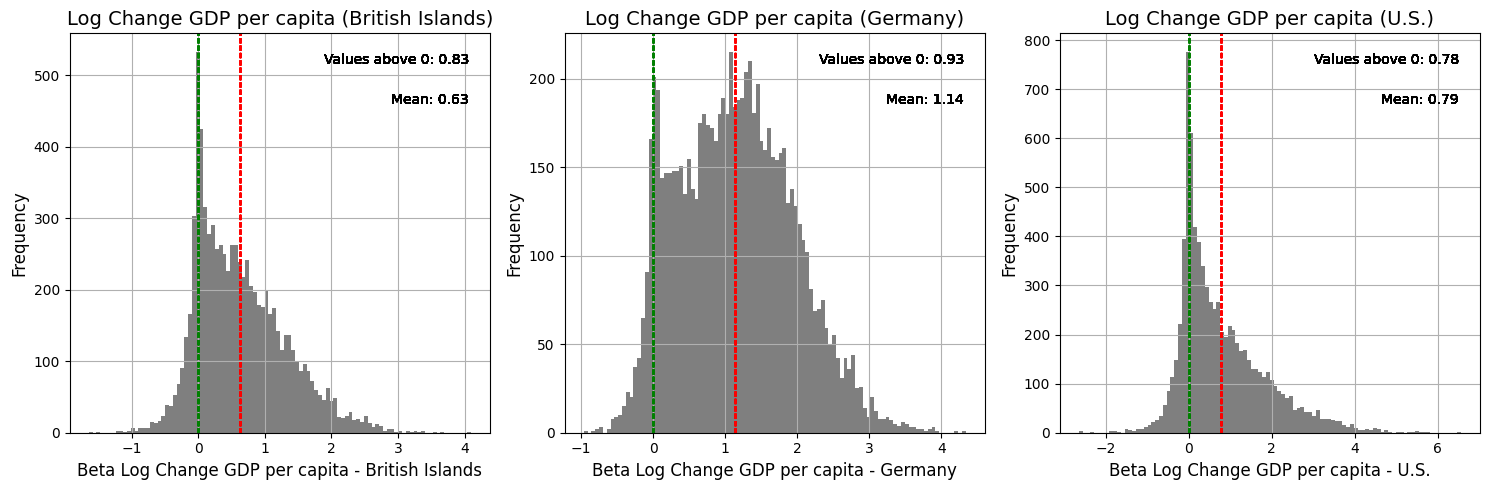

In [43]:
df = copy.deepcopy(only_genpareto_gdp.reset_index())
groups = df['Group'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

groups_to_plot = ['British Islands', 'Germany', 'U.S.']

for i, group in enumerate(groups):
    group_df = df[df['Group'] == group]
    i = 0
    for j, group in enumerate(groups_to_plot):
        column = 'beta_log_change_gdp_pc'
        ax = axes[j]
        group_df = df[df['Group'] == group].dropna()
        group_df[column].dropna().hist(bins=100, ax=ax)
        ax.axvline(group_df[column].mean(), color='red', linestyle='dashed', linewidth=1)
        ax.axvline(0, color='green', linestyle='dashed', linewidth=1)
        ax.text(0.95, 0.85, f'Mean: {group_df[column].mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
        ax.text(0.95, 0.95, f'Values above 0: {(group_df[column] > 0).mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
        ax.set_title(f'Log Change GDP per capita ({group})', fontsize=14)
        ax.set_xlabel('Beta Log Change GDP per capita - ' + group, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

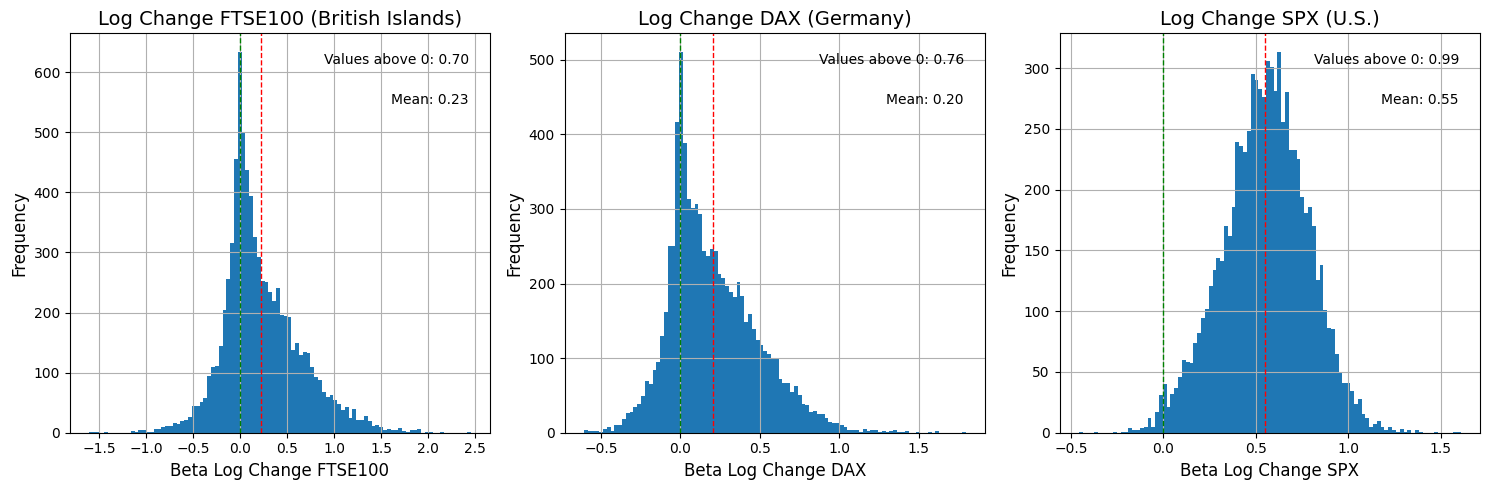

In [29]:
df = copy.deepcopy(only_genpareto_stock_market.reset_index())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df[df['Group'] == 'British Islands']['beta_log_change_FTSE100'].hist(bins=100, ax=axes[0])
ax=axes[0]
ax.axvline(df[df['Group'] == 'British Islands']['beta_log_change_FTSE100'].mean(), color='red', linestyle='dashed', linewidth=1)
ax.axvline(0, color='green', linestyle='dashed', linewidth=1)
ax.text(0.95, 0.85, f'Mean: {df[df['Group'] == "British Islands"]["beta_log_change_FTSE100"].mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
ax.text(0.95, 0.95, f'Values above 0: {(df[df['Group'] == "British Islands"]["beta_log_change_FTSE100"] > 0).mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
ax.set_title('Log Change FTSE100 (British Islands)', fontsize=14)
ax.set_xlabel('Beta Log Change FTSE100', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
df[df['Group'] == 'Germany']['beta_log_change_DAX'].hist(bins=100, ax=axes[1])
ax=axes[1]
ax.axvline(df[df['Group'] == 'Germany']['beta_log_change_DAX'].mean(), color='red', linestyle='dashed', linewidth=1)
ax.axvline(0, color='green', linestyle='dashed', linewidth=1)
ax.text(0.95, 0.85, f'Mean: {df[df['Group'] == "Germany"]["beta_log_change_DAX"].mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
ax.text(0.95, 0.95, f'Values above 0: {(df[df['Group'] == "Germany"]["beta_log_change_DAX"] > 0).mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
ax.set_title('Log Change DAX (Germany)', fontsize=14)
ax.set_xlabel('Beta Log Change DAX', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
df[df['Group'] == 'U.S.']['beta_log_change_SPX'].hist(bins=100, ax=axes[2])
ax=axes[2]
ax.axvline(df[df['Group'] == 'U.S.']['beta_log_change_SPX'].mean(), color='red', linestyle='dashed', linewidth=1)
ax.axvline(0, color='green', linestyle='dashed', linewidth=1)
ax.text(0.95, 0.85, f'Mean: {df[df['Group'] == "U.S."]["beta_log_change_SPX"].mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
ax.text(0.95, 0.95, f'Values above 0: {(df[df['Group'] == "U.S."]["beta_log_change_SPX"] > 0).mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
ax.set_title('Log Change SPX (U.S.)', fontsize=14)
ax.set_xlabel('Beta Log Change SPX', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

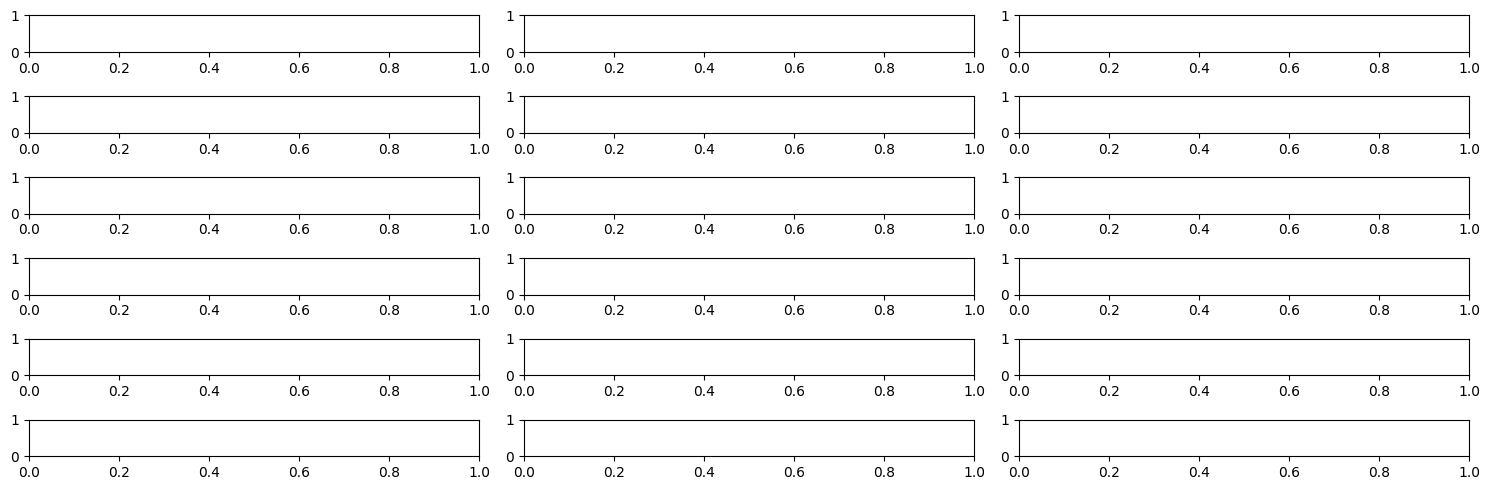

In [30]:
df = copy.deepcopy(only_genpareto_gdp.reset_index())
groups = df['Group'].unique()

fig, axes = plt.subplots(6, 3, figsize=(15, 5))

groups_to_plot = ['British Islands', 'Germany', 'U.S.']

for i, group in enumerate(groups):
    group_df = df[df['Group'] == group]
    j = 0
    for i in range(1):
        for j in range(3):
            group = groups[3*i+j]
            if group not in groups_to_plot:
                continue
            column = 'beta_log_change_gdp_pc'
            ax = axes[i, j]
            group_df = df[df['Group'] == group].dropna()
            group_df[column].dropna().hist(bins=100, ax=ax)
            ax.axvline(group_df[column].mean(), color='red', linestyle='dashed', linewidth=1)
            ax.axvline(0, color='green', linestyle='dashed', linewidth=1)
            ax.text(0.95, 0.85, f'Mean: {group_df[column].mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
            ax.text(0.95, 0.95, f'Values above 0: {(group_df[column] > 0).mean():.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
            ax.set_title(f'Log Change GDP per capita ({group})', fontsize=12)
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Bayesian R^2

In [31]:
df = read_panel_data(observations_threshold=0)

In [32]:
only_two_cov_models = models_df[models_df['Covariates'].apply(lambda x: len(x) == 2)]
only_two_cov_models = only_two_cov_models.groupby(['Group', 'Model']).apply(lambda x: x.loc[x['End Year'].idxmax()], include_groups=False)
only_two_cov_models.reset_index(inplace=True)

In [33]:
only_genpareto_all_cov_models = only_all_cov_models[only_all_cov_models['Model'] == 'GeneralisedPareto']
only_genpareto_two_cov_models = only_two_cov_models[only_two_cov_models['Model'] == 'GeneralisedPareto']

In [34]:
path = "../../Stored_Results/bayesian_time_series_analysis/r2_df_gpd_2cov.pkl"
rebuild = False

if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        r2_df_gpd_2cov = dill.load(f)
else:
    r_2_dict = {}
    for i, model_row in only_genpareto_two_cov_models.iterrows():
        model = train_or_retrieve_time_series_model(
            panel_df=df,
            group=model_row['Group'],
            start_year=model_row['Start Year'],
            end_year=model_row['End Year'],
            model_type=model_row['Model'],
            covariates=model_row['Covariates'],
            retrain_if_saved=False
        )
        model_post_pred = model.posterior_predictive().dropna(axis=0)
        start_year = model_row['Start Year']
        end_year = model_row['End Year']
        start_year = max(start_year, end_year-14)
        r_2s = []
        for j, row in model_post_pred.iterrows():
            log_sigma_changes = []
            epsilons = []
            for year in range(start_year+1, end_year+1):
                sigma_old = row[f'sigma_{year-1}']
                sigma_new = row[f'sigma_{year}']
                log_sigma_old = np.log(sigma_old)
                log_sigma_new = np.log(sigma_new)
                log_change_sigma = (log_sigma_new - log_sigma_old)
                epsilon = row[f'epsilon_{year}']
                log_sigma_changes.append(log_change_sigma)
                epsilons.append(epsilon)
            log_sigma_changes = np.array(log_sigma_changes)
            epsilons = np.array(epsilons)
            explained_variance=np.var(log_sigma_changes)
            residual_variance=np.var(epsilons)
            r2 = explained_variance / (explained_variance + residual_variance)
            r_2s.append(r2)
        r_2s = np.array(r_2s)
        r_2_dict[model_row['Group']] = r_2s
    
    r2_df_gpd_2cov = pd.DataFrame(r_2_dict)

    with open(path, 'wb') as f:
        dill.dump(r2_df_gpd_2cov, f)

In [35]:
path = "../../Stored_Results/bayesian_time_series_analysis/r2_df_gpd_3cov.pkl"
rebuild = False

if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        r2_df_gpd_3cov = dill.load(f)
else:
    r_2_dict = {}
    for i, model_row in only_genpareto_all_cov_models.iterrows():
        model = train_or_retrieve_time_series_model(
            panel_df=df,
            group=model_row['Group'],
            start_year=model_row['Start Year'],
            end_year=model_row['End Year'],
            model_type=model_row['Model'],
            covariates=model_row['Covariates'],
            retrain_if_saved=False
        )
        model_post_pred = model.posterior_predictive().dropna(axis=0)
        start_year = model_row['Start Year']
        end_year = model_row['End Year']
        start_year = max(start_year, end_year-14)
        r_2s = []
        for j, row in model_post_pred.iterrows():
            log_sigma_changes = []
            epsilons = []
            for year in range(start_year+1, end_year+1):
                sigma_old = row[f'sigma_{year-1}']
                sigma_new = row[f'sigma_{year}']
                log_sigma_old = np.log(sigma_old)
                log_sigma_new = np.log(sigma_new)
                log_change_sigma = (log_sigma_new - log_sigma_old)
                epsilon = row[f'epsilon_{year}']
                log_sigma_changes.append(log_change_sigma)
                epsilons.append(epsilon)
            log_sigma_changes = np.array(log_sigma_changes)
            epsilons = np.array(epsilons)
            explained_variance=np.var(log_sigma_changes)
            residual_variance=np.var(epsilons)
            r2 = explained_variance / (explained_variance + residual_variance)
            r_2s.append(r2)
        r_2s = np.array(r_2s)
        r_2_dict[model_row['Group']] = r_2s
    
    r2_df_gpd_3cov = pd.DataFrame(r_2_dict)

    with open(path, 'wb') as f:
        dill.dump(r2_df_gpd_3cov, f)

In [36]:
summary_r2_df_gpd_2cov = r2_df_gpd_2cov.describe()
summary_r2_df_gpd_3cov = r2_df_gpd_3cov.describe()
summary_r2_df_gpd_2cov['Average'] = summary_r2_df_gpd_2cov.mean(axis=1)
summary_r2_df_gpd_3cov['Average'] = summary_r2_df_gpd_3cov.mean(axis=1)

In [37]:
summary_r2_df_gpd_2cov.T

count      mean       std       min       25%       50%  \
Alps             8000.0  0.618168  0.171907  0.098010  0.499442  0.534295   
Asian Islands    8000.0  0.590526  0.150046  0.257119  0.499079  0.518782   
Australia        8000.0  0.615726  0.172066  0.076571  0.499051  0.531758   
Brazil           8000.0  0.537905  0.110109  0.230199  0.495190  0.501933   
British Islands  8000.0  0.721584  0.181666  0.324956  0.537544  0.708544   
Canada           8000.0  0.631963  0.175604  0.254064  0.500282  0.545454   
China            8000.0  0.501285  0.022329  0.250899  0.495055  0.500143   
France           8000.0  0.611365  0.166808  0.139945  0.499196  0.535740   
Germany          8000.0  0.809198  0.173040  0.364371  0.669704  0.865870   
India            8000.0  0.581484  0.138772  0.222311  0.498780  0.516248   
Israel + Turkey  8000.0  0.600843  0.158399  0.177925  0.499118  0.524112   
Italy            8000.0  0.617651  0.172772  0.088057  0.499165  0.538839   
Japan            8000.0  0.572055  0.143334  0.122734  0.496256  0.510775   
Russia           8000.0  0.609645  0.175415  0.092031  0.496109  0.540087   
Scandinavia      8000.0  0.618644  0.186118  0.037857  0.496690  0.543655   
South Korea      8000.0  0.555255  0.133278  0.085709  0.493233  0.506347   
Southeast Asia   8000.0  0.580723  0.148801  0.129015  0.496639  0.515932   
U.S.             8000.0  0.669987  0.107162  0.339670  0.587698  0.673822   
Average          8000.0  0.613556  0.149312  0.182858  0.514346  0.561796   

                      75%       max  
Alps             0.709149  0.999887  
Asian Islands    0.634088  0.999725  
Australia        0.716790  0.999800  
Brazil           0.532923  0.996535  
British Islands  0.900021  0.999891  
Canada           0.752776  0.999929  
China            0.506208  0.799253  
France           0.703943  0.999775  
Germany          0.964870  0.999986  
India            0.615358  0.999415  
Israel + Turkey  0.667873  0.999919  
Italy            0.728322  0.999915  
Japan            0.603252  0.999837  
Russia           0.721036  0.999957  
Scandinavia      0.746228  0.999937  
South Korea      0.577782  0.999939  
Southeast Asia   0.623997  0.999496  
U.S.             0.747081  0.972679  
Average          0.691761  0.986993

In [38]:
summary_r2_df_gpd_3cov.T

count      mean       std       min       25%       50%  \
Alps             8000.0  0.678957  0.182217  0.152071  0.520318  0.640675   
Asian Islands    8000.0  0.663396  0.173419  0.286094  0.514730  0.610283   
Australia        8000.0  0.637471  0.178708  0.153577  0.501616  0.575981   
Brazil           8000.0  0.531980  0.098228  0.244998  0.487046  0.506140   
British Islands  8000.0  0.779908  0.177319  0.300826  0.621990  0.812674   
Canada           8000.0  0.645050  0.169068  0.231191  0.507723  0.590197   
China            8000.0  0.608896  0.114830  0.264118  0.511993  0.586689   
France           8000.0  0.652292  0.184413  0.167051  0.505224  0.594544   
Germany          8000.0  0.845387  0.153431  0.325089  0.745470  0.899655   
India            8000.0  0.640936  0.167152  0.237627  0.509757  0.580469   
Israel + Turkey  8000.0  0.679395  0.178971  0.237373  0.520609  0.637809   
Italy            8000.0  0.660351  0.189207  0.032461  0.506950  0.603405   
Japan            8000.0  0.616451  0.173646  0.104630  0.496982  0.552088   
Russia           8000.0  0.650043  0.198076  0.059035  0.498969  0.601097   
Scandinavia      8000.0  0.672547  0.204494  0.023298  0.507087  0.641145   
South Korea      8000.0  0.643952  0.196204  0.025893  0.498024  0.582192   
Southeast Asia   8000.0  0.634056  0.176038  0.129842  0.501559  0.574637   
U.S.             8000.0  0.782209  0.081084  0.419603  0.731604  0.790440   
Average          8000.0  0.667960  0.166473  0.188599  0.538203  0.632229   

                      75%       max  
Alps             0.843133  0.999907  
Asian Islands    0.809346  0.999989  
Australia        0.768816  0.999984  
Brazil           0.544520  0.999950  
British Islands  0.949332  0.999942  
Canada           0.767930  0.999858  
China            0.689839  0.983178  
France           0.802446  0.999993  
Germany          0.977091  0.999992  
India            0.752059  0.999869  
Israel + Turkey  0.839403  0.999876  
Italy            0.827386  0.999935  
Japan            0.719769  0.999984  
Russia           0.821311  0.999974  
Scandinavia      0.863850  0.999993  
South Korea      0.807129  0.999961  
Southeast Asia   0.762255  0.999785  
U.S.             0.840732  0.974497  
Average          0.799241  0.997593

In [44]:
dataframe_to_latex_table(
    df=summary_r2_df_gpd_2cov.T,
    label='tab:ts_r2_gpd_2cov_summary',
    caption='Summary statistics of the alternative $R^2$ values of the Generalised Pareto model with two covariates',
    n_decimals=2
)

\begin{table}
\caption{Summary statistics of the $R^2$ values of the Generalised Pareto model with two covariates}
\label{tab:ts_r2_gpd_2cov_summary}
\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
Alps & 8000.00 & 0.62 & 0.17 & 0.10 & 0.50 & 0.53 & 0.71 & 1.00 \\
Asian Islands & 8000.00 & 0.59 & 0.15 & 0.26 & 0.50 & 0.52 & 0.63 & 1.00 \\
Australia & 8000.00 & 0.62 & 0.17 & 0.08 & 0.50 & 0.53 & 0.72 & 1.00 \\
Brazil & 8000.00 & 0.54 & 0.11 & 0.23 & 0.50 & 0.50 & 0.53 & 1.00 \\
British Islands & 8000.00 & 0.72 & 0.18 & 0.32 & 0.54 & 0.71 & 0.90 & 1.00 \\
Canada & 8000.00 & 0.63 & 0.18 & 0.25 & 0.50 & 0.55 & 0.75 & 1.00 \\
China & 8000.00 & 0.50 & 0.02 & 0.25 & 0.50 & 0.50 & 0.51 & 0.80 \\
France & 8000.00 & 0.61 & 0.17 & 0.14 & 0.50 & 0.54 & 0.70 & 1.00 \\
Germany & 8000.00 & 0.81 & 0.17 & 0.36 & 0.67 & 0.87 & 0.96 & 1.00 \\
India & 8000.00 & 0.58 & 0.14 & 0.22 & 0.50 & 0.52 & 0.62 & 1.00 \\
Israel + Turkey & 8000.00 & 0.60 & 0.16 & 0.

In [45]:
dataframe_to_latex_table(
    df=summary_r2_df_gpd_3cov.T,
    label='tab:ts_r2_gpd_3cov_summary',
    caption='Summary statistics of the alternative $R^2$ values of the Generalised Pareto model with three covariates',
    n_decimals=2
)

\begin{table}
\caption{Summary statistics of the $R^2$ values of the Generalised Pareto model with three covariates}
\label{tab:ts_r2_gpd_3cov_summary}
\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
Alps & 8000.00 & 0.68 & 0.18 & 0.15 & 0.52 & 0.64 & 0.84 & 1.00 \\
Asian Islands & 8000.00 & 0.66 & 0.17 & 0.29 & 0.51 & 0.61 & 0.81 & 1.00 \\
Australia & 8000.00 & 0.64 & 0.18 & 0.15 & 0.50 & 0.58 & 0.77 & 1.00 \\
Brazil & 8000.00 & 0.53 & 0.10 & 0.24 & 0.49 & 0.51 & 0.54 & 1.00 \\
British Islands & 8000.00 & 0.78 & 0.18 & 0.30 & 0.62 & 0.81 & 0.95 & 1.00 \\
Canada & 8000.00 & 0.65 & 0.17 & 0.23 & 0.51 & 0.59 & 0.77 & 1.00 \\
China & 8000.00 & 0.61 & 0.11 & 0.26 & 0.51 & 0.59 & 0.69 & 0.98 \\
France & 8000.00 & 0.65 & 0.18 & 0.17 & 0.51 & 0.59 & 0.80 & 1.00 \\
Germany & 8000.00 & 0.85 & 0.15 & 0.33 & 0.75 & 0.90 & 0.98 & 1.00 \\
India & 8000.00 & 0.64 & 0.17 & 0.24 & 0.51 & 0.58 & 0.75 & 1.00 \\
Israel + Turkey & 8000.00 & 0.68 & 0.18 & 

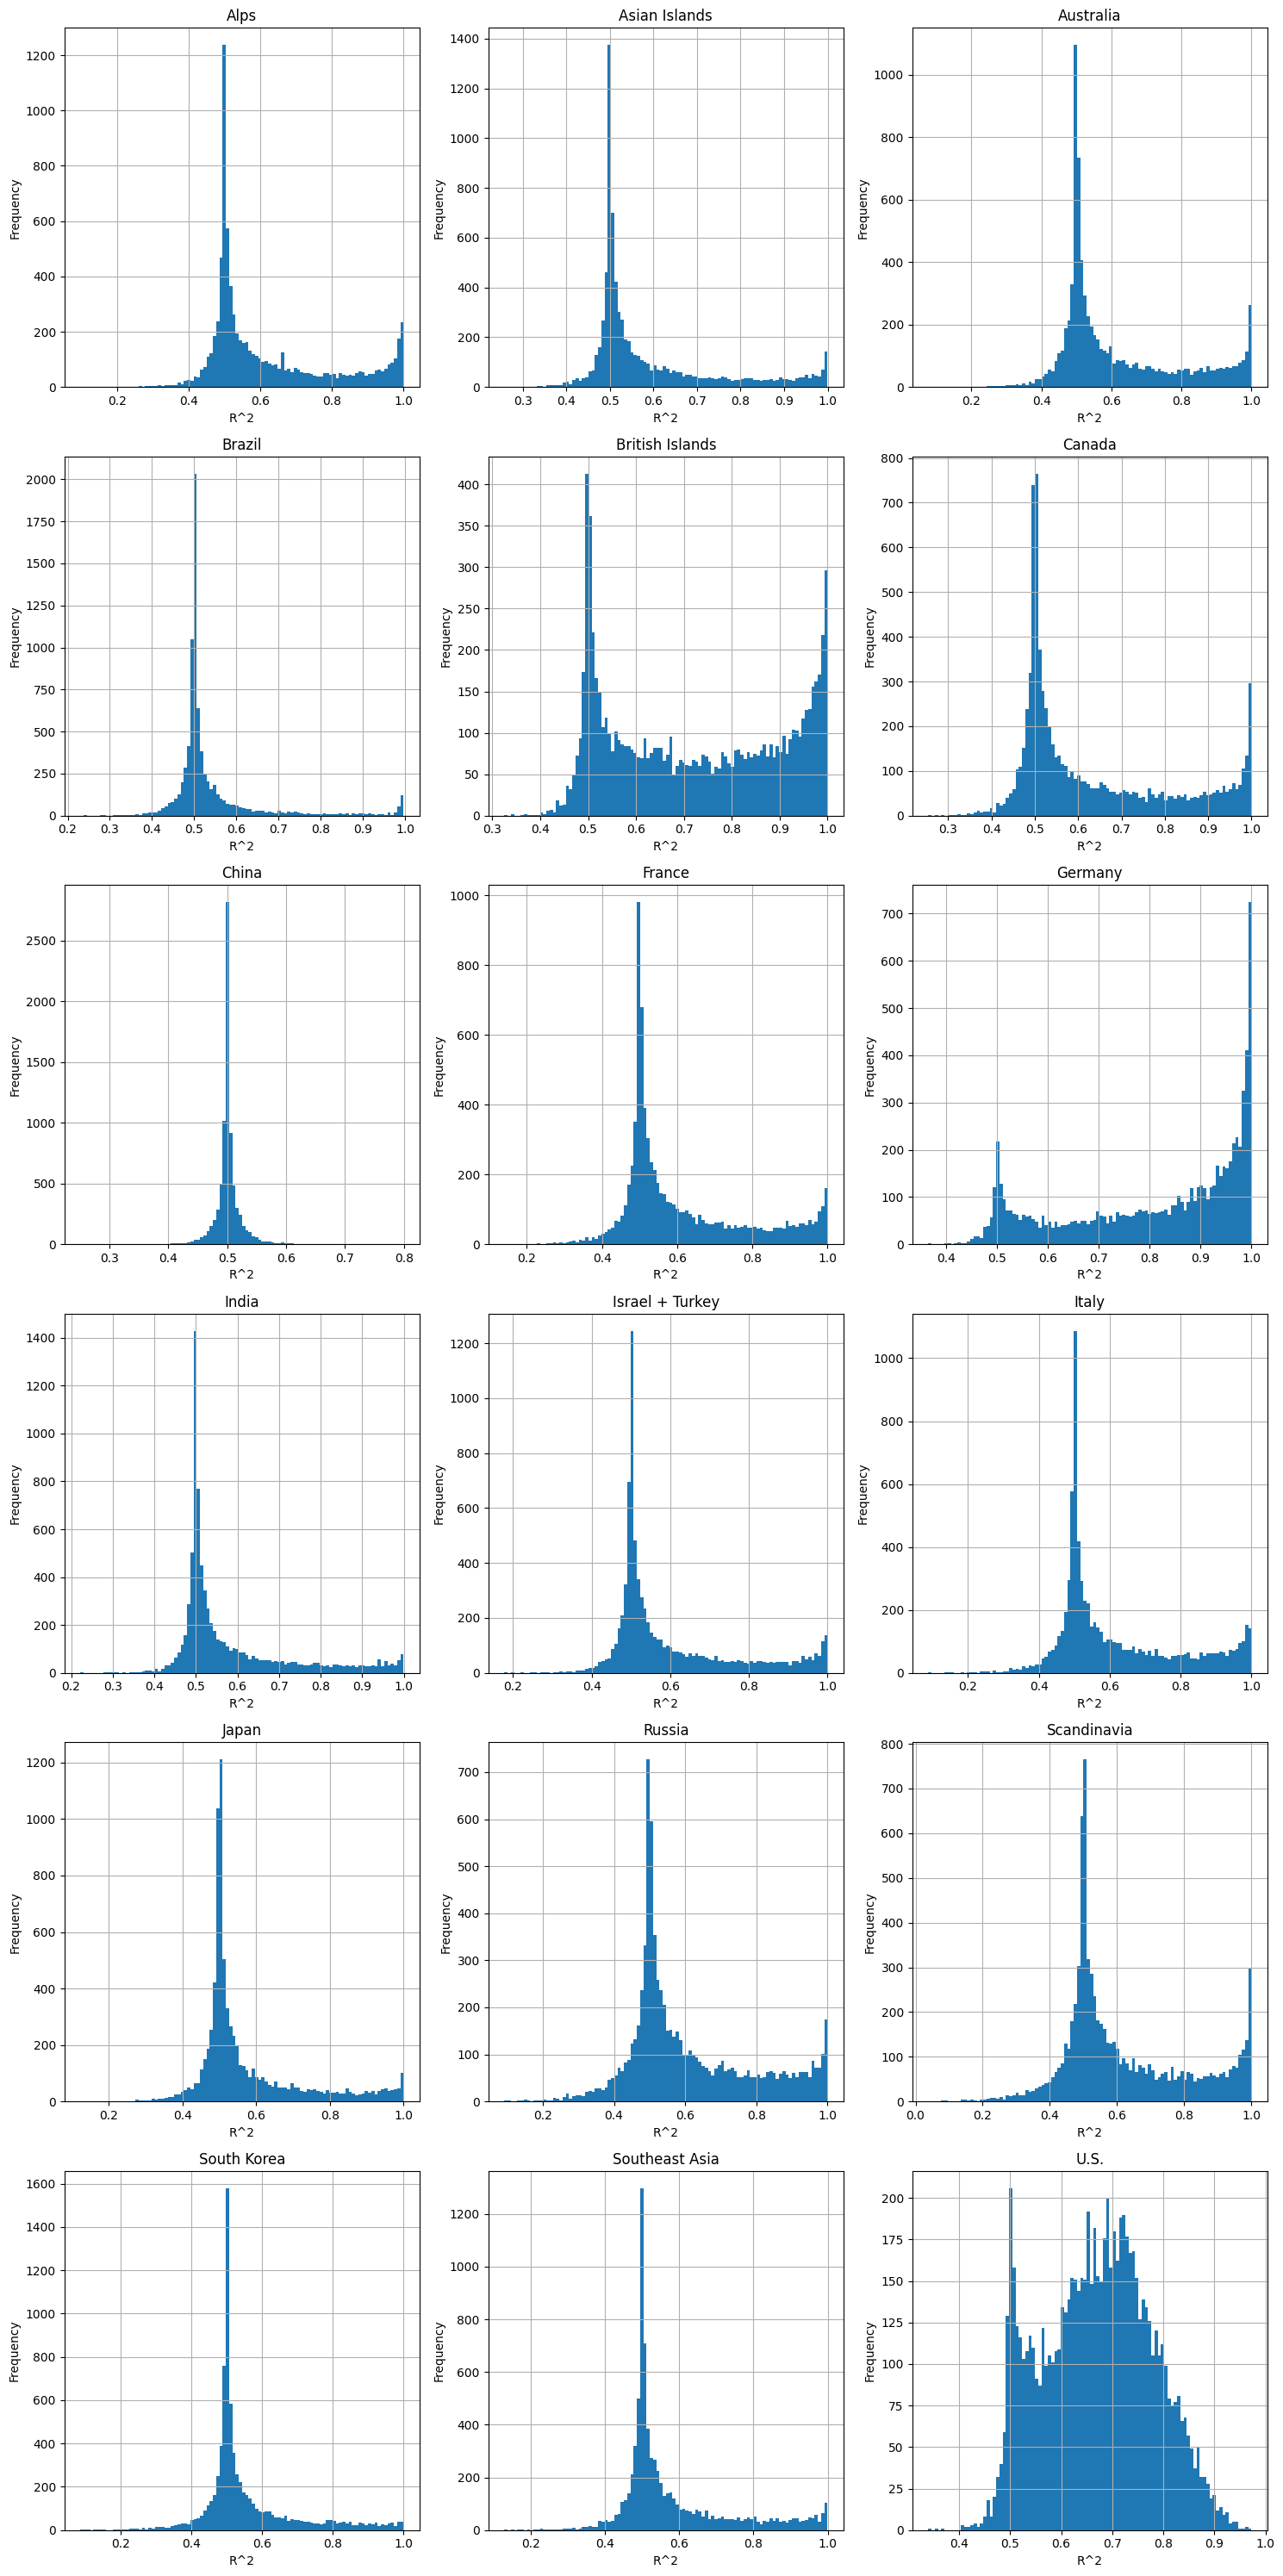

In [39]:
# Plot a 6*3 grid of histograms of the R^2 values for the Generalised Pareto model
countries = r2_df_gpd_2cov.columns
fig, axes = plt.subplots(6, 3, figsize=(15, 30))
for i, country in enumerate(countries):
    ax = axes[i//3, i%3]
    r2_df_gpd_2cov[country].hist(bins=100, ax=ax)
    ax.set_title(country)
    ax.set_xlabel('R^2')
    ax.set_ylabel('Frequency')
plt.tight_layout()

Index(['beta_constant', 'beta_log_change_CAC40', 'beta_log_change_DAX',
       'beta_log_change_FTSE100', 'beta_log_change_MOEX',
       'beta_log_change_MSCI', 'beta_log_change_NIFTY',
       'beta_log_change_OMX40', 'beta_log_change_SPX', 'beta_log_change_SSE',
       'beta_log_change_gdp_pc'],
      dtype='object')


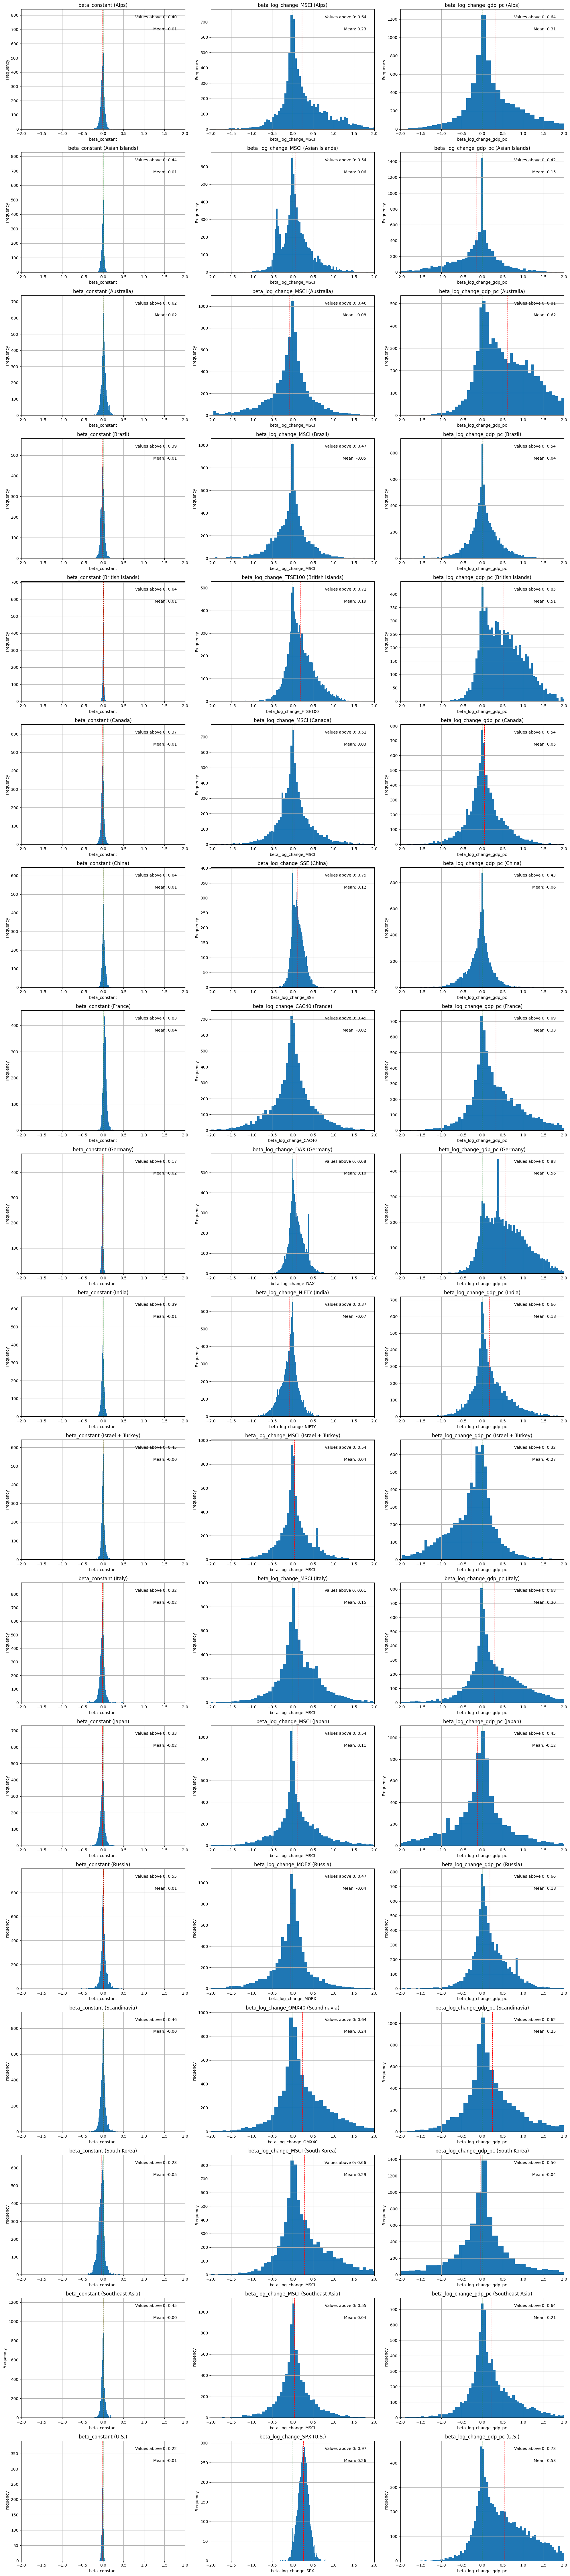

In [40]:
plot_histograms_grid(only_pareto_params)

Index(['beta_constant', 'beta_log_change_CAC40', 'beta_log_change_DAX',
       'beta_log_change_FTSE100', 'beta_log_change_MOEX',
       'beta_log_change_MSCI', 'beta_log_change_NIFTY',
       'beta_log_change_OMX40', 'beta_log_change_SPX', 'beta_log_change_SSE',
       'beta_log_change_gdp_pc'],
      dtype='object')


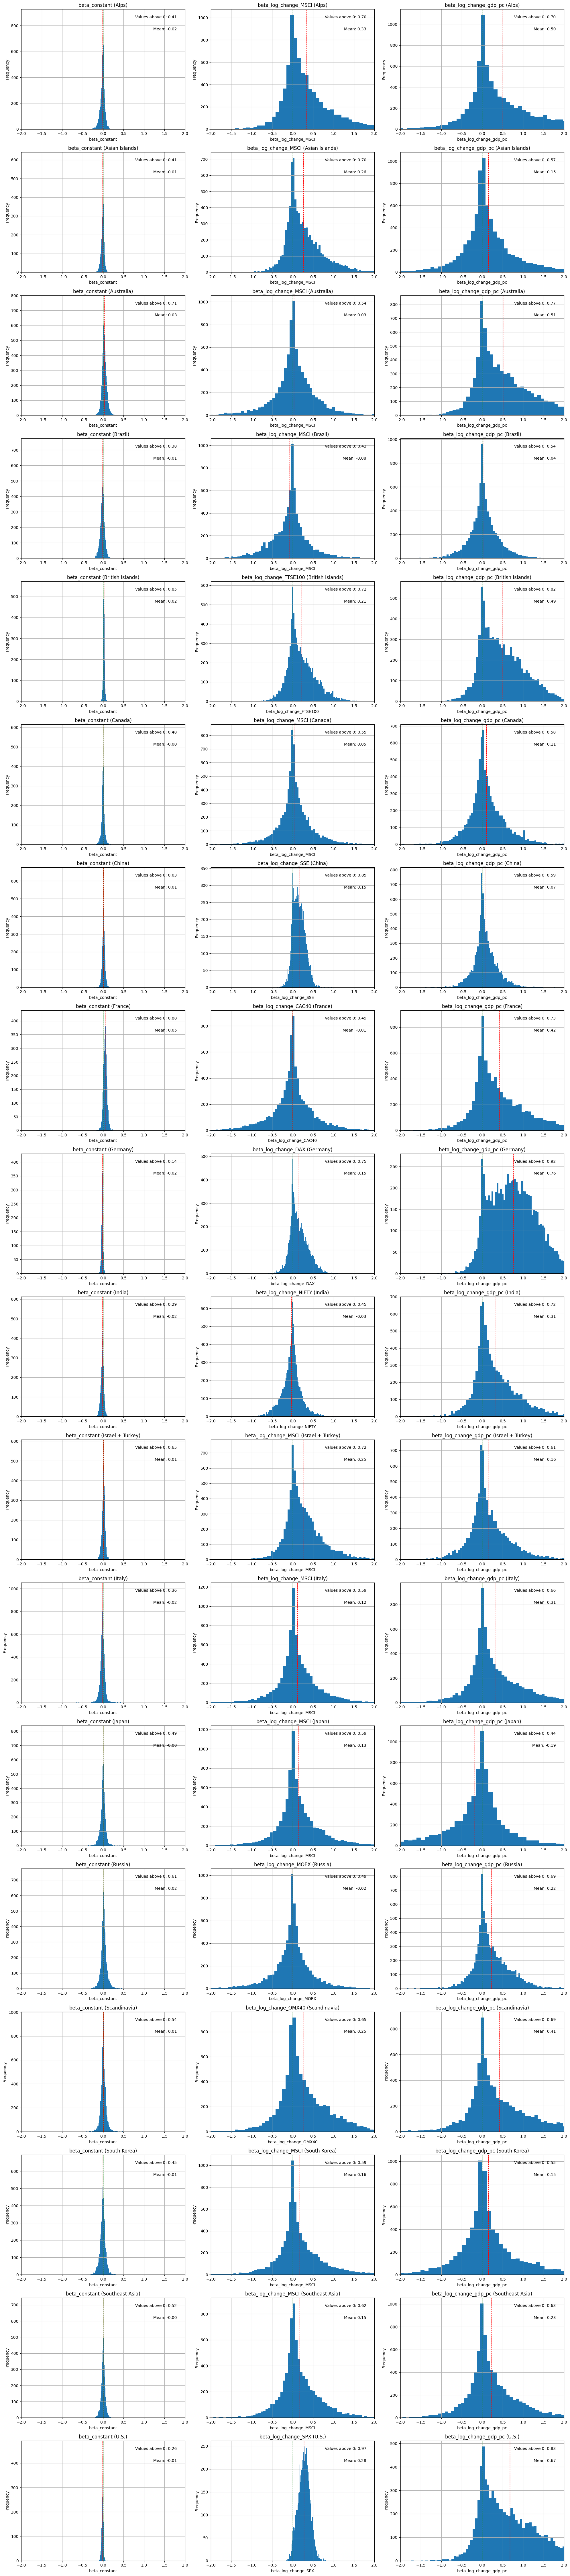

In [41]:
plot_histograms_grid(only_weibull_params)

Index(['beta_constant', 'beta_log_change_CAC40', 'beta_log_change_DAX',
       'beta_log_change_FTSE100', 'beta_log_change_MOEX',
       'beta_log_change_MSCI', 'beta_log_change_NIFTY',
       'beta_log_change_OMX40', 'beta_log_change_SPX', 'beta_log_change_SSE',
       'beta_log_change_gdp_pc'],
      dtype='object')


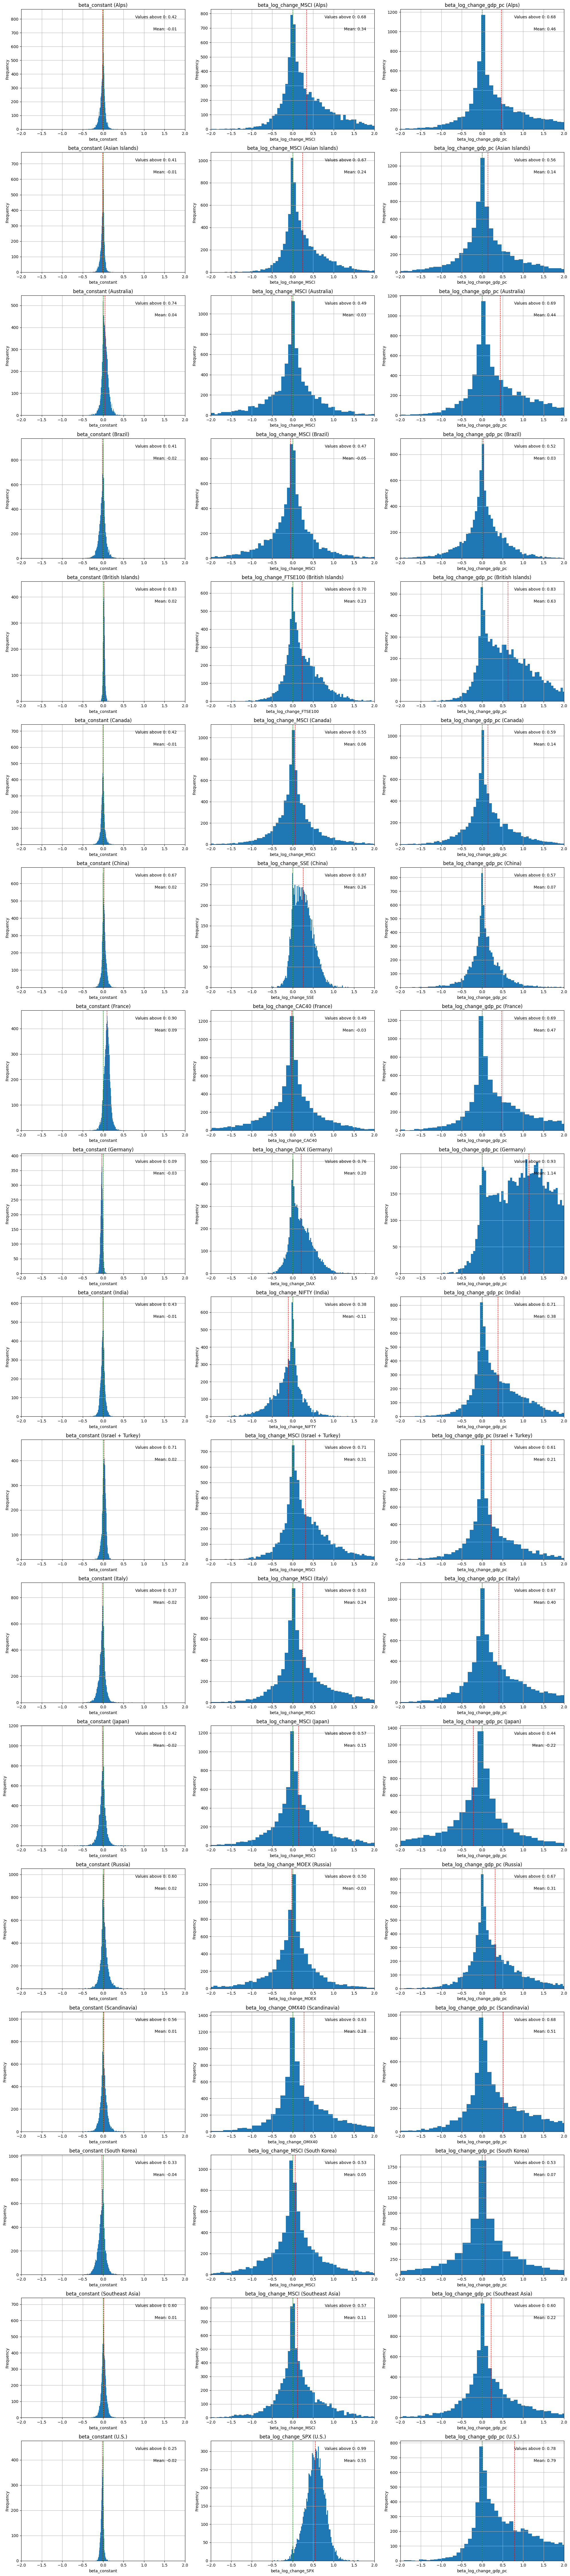

In [42]:
plot_histograms_grid(only_genpareto_params)